In [31]:
import pandas as pd
import pandas_profiling as pf
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score
path_train='./train_data.csv'
path_test='./test_data.csv'

train_df=pd.read_csv(path_train, low_memory=False)
test_df=pd.read_csv(path_test, low_memory=False)

In [3]:
#Splitting X and Y data
x_train=train_df.drop(['stream_quality'],axis=1)
y_train=train_df['stream_quality']

x_test=test_df.drop(['stream_quality'],axis=1)
y_test=test_df['stream_quality']

x_train.dtypes


pf.ProfileReport(x_train)

fps_mean               float64
fps_std                float64
fps_lags                 int64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
auto_bitrate_state      object
auto_fec_state          object
auto_fec_mean          float64
dtype: object

In [4]:
from sklearn.preprocessing import LabelEncoder


label_encoder=LabelEncoder()

x_train['auto_bitrate_state']=label_encoder.fit_transform(x_train['auto_bitrate_state'])
x_train['auto_fec_state']=label_encoder.fit_transform(x_train['auto_fec_state'])
x_test['auto_bitrate_state']=label_encoder.fit_transform(x_test['auto_bitrate_state'])
x_test['auto_fec_state']=label_encoder.fit_transform(x_test['auto_fec_state'])


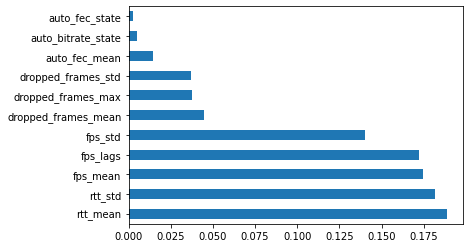

[0.17428526 0.14017428 0.17214061 0.18902387 0.18184428 0.04498216
 0.0372664  0.03762057 0.00517576 0.00278049 0.01470632]


In [5]:
#Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt#Fit the model
model = ExtraTreesClassifier()
model.fit(x_train,y_train)
feat_importances  = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()
print(model.feature_importances_)#plot graph of feature importances



In [6]:
#Selecting most ignored features to drop them

weight = model.feature_importances_
dropped_columns = [feature for feature, w in zip(x_train.columns, weight) if (w < 0.1).any() ]
dropped_columns
x_train_featured = x_train.drop(dropped_columns,axis=1)
x_test_featured = x_test.drop(dropped_columns,axis=1)

display(x_train_featured)


,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std
0,24.4,0.516398,0,91.1,6.723921
1,28.6,2.065591,0,99.7,15.923777
2,30.0,0.000000,0,98.1,11.798776
3,30.3,0.948683,0,99.4,13.014522
4,29.9,0.316228,0,123.2,62.476307
...,...,...,...,...,...
406567,40.0,0.000000,0,0.0,0.000000
406568,40.0,0.000000,0,0.0,0.000000
406569,40.0,0.000000,0,0.0,0.000000
406570,40.0,0.000000,0,0.0,0.000000


In [7]:
##Scaling Using Standard Scaler#
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train_featured)
scaler.fit(x_train_featured)

x_train_scaled = pd.DataFrame(scaler.transform(x_train_featured), columns=x_train_featured.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test_featured), columns=x_test_featured.columns)

x_train_scaled.shape
x_train_scaled.describe()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std
count,4.065720e+05,4.065720e+05,4.065720e+05,4.065720e+05,4.065720e+05
mean,5.407907e-16,1.554703e-16,-5.676345e-17,-3.075852e-17,1.426077e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.967410e+00,-6.162789e-01,-1.665943e-01,-4.057192e-01,-1.248689e-01
25%,-5.331015e-01,-5.310085e-01,-1.665943e-01,-3.003946e-01,-1.203972e-01
50%,-3.868710e-01,-3.481323e-01,-1.665943e-01,-1.644438e-01,-1.153353e-01
75%,7.313624e-01,8.226846e-02,-1.665943e-01,2.080795e-02,-9.075382e-02
max,7.965472e+00,8.366002e+01,8.929422e+00,9.594311e+01,2.603053e+02


In [ ]:
#Profiling
report=pf.ProfileReport(x_train_scaled)
report

In [8]:
#Detecting and removing Outliers with Zscore since we have already normalizingly disturbuted scaled our data
print(x_train_scaled.shape)
data_abs = np.abs(x_train_scaled)#get the absoulte value od scaled data
filter = (data_abs < 3).all(axis=1)

x_train=x_train_scaled[filter]
y_train=y_train[filter]
print(x_train.shape)
print(y_train.shape)


(406572, 5)
(389424, 5)
(389424,)


0    370196
1     19228
Name: stream_quality, dtype: int64


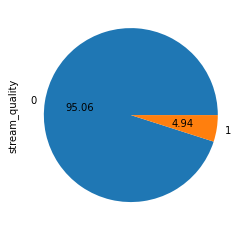

In [9]:
#Balancing data
print(y_train.value_counts())
y_train.value_counts().plot.pie(autopct='%.2f')


0    370196
1    370196
Name: stream_quality, dtype: int64


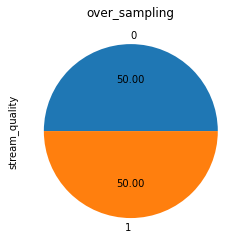

In [10]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(sampling_strategy="not majority")
x_balanced, y_balanced = ros.fit_resample(x_train,y_train)

ax=y_balanced.value_counts().plot.pie(autopct='%.2f')

_=ax.set_title("over_sampling")
print(y_balanced.value_counts())



In [23]:
#Classification
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

###Testing Unbalanced Data####

clf = LogisticRegression(penalty='l1',random_state=0, solver='liblinear').fit(x_train, y_train)##activating Lasso Regularization, 
y_test_pred = clf.predict(x_test_scaled)


# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Testing F1 = {}'.format(f1_score(y_test, y_test_pred,)))
print('Testing Weighted F1 = {}'.format(f1_score(y_test, y_test_pred,average='weighted')))


Testing accuracy = 0.9375400252877716
Testing precision = 0.5427754956242186
Testing recall = 0.19364088186568115
Testing F1 = 0.28544592119475887
Testing Weighted F1 = 0.9234105895499422


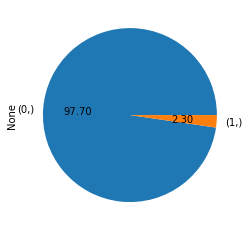

In [21]:
pd.DataFrame(y_test_pred).value_counts().plot.pie(autopct='%.2f')


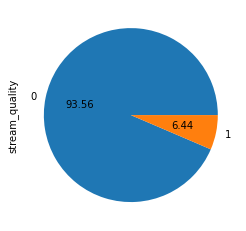

In [12]:
y_test.value_counts().plot.pie(autopct='%.2f')

Testing accuracy = 0.8146192876730324
Testing precision = 0.1951285128926783
Testing recall = 0.6008028545941124
Testing F1 = 0.2945826043489128
Testing Weighted F1 = 0.8547155050943877


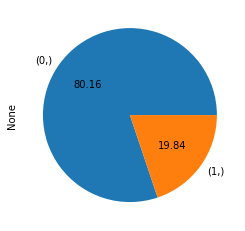

In [15]:
###Testing balanced Data####
clf = LogisticRegression(penalty='l1',random_state=0, solver='liblinear').fit(x_balanced, y_balanced)
y_pred = clf.predict(x_test_scaled)


# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred)))
print('Testing F1 = {}'.format(f1_score(y_test, y_pred, )))
print('Testing Weighted F1 = {}'.format(f1_score(y_test, y_pred,average='weighted')))

pd.DataFrame(y_pred).value_counts().plot.pie(autopct='%.2f')




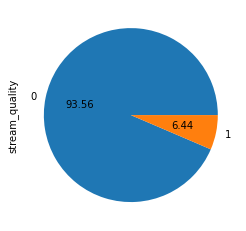

In [14]:
y_test.value_counts().plot.pie(autopct='%.2f')

In [24]:
# Logistic Regression Coefficients for balanced data
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(x_balanced.columns), clf.coef_[0])], sep='\n')

----Logistic Regression Coefficients----
('fps_mean', -0.20556983285577288)
('fps_std', 0.551867629328876)
('fps_lags', 1.091177122626557)
('rtt_mean', 0.29282501554851814)
('rtt_std', 0.35068750785645614)


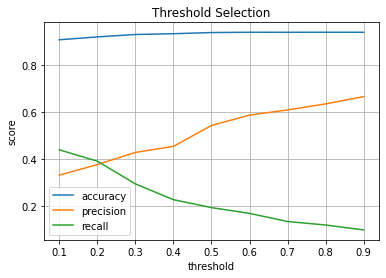

In [26]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pred_proba = clf.predict_proba(x_test_scaled)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr))
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr))
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr))
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

In [27]:
from sklearn.metrics import confusion_matrix

print('sklearn Confusion Matrix for Test:\n', confusion_matrix(y_test, clf.predict(x_test_scaled)), '\n')

sklearn Confusion Matrix for Test:
 [[225342   2560]
 [ 12655   3039]] 

